# Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import fitz
from math import *

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Flatten, 
                                    Dense, Dropout, 
                                    MaxPool2D, GlobalAveragePooling2D, 
                                    MaxPooling2D, AveragePooling2D, 
                                    AvgPool2D)
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json

# Пути к папкам с документами

In [3]:
main_path = "L:\\АвтоСтатистика\\Распознавание текста\\text_recognising\\russian_shrift\\"
main_path = "C:\\Users\\с\\Desktop\\Распознавание текста\\text_recognising\\russian_shrift\\"

In [4]:
path_pdf = 'ALL_PDF/'
path_png = 'ALL_PNG/'
path_png_cor = 'ALL_PNG_correct/'
path_png_detected = 'ALL_PNG_detected/'
model_path = 'MODELS/' 

In [5]:
#путь к исходникам pdf
path_pdf = main_path + "DOCS_ALL\\ALL_PDF\\"
#путь к исходникам png
path_png = main_path + "DOCS_ALL\\ALL_PNG\\"
#путь к выровненным png
path_png_cor = main_path + "DOCS_ALL\\ALL_PNG_correct\\"
path_png_detected = main_path + "DOCS_ALL\\ALL_PNG_detected\\"
model_path = main_path + "models\\" 

In [6]:
# настройка шрифтов для печати сообщений
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    NEGATIVE = '\033[7m'
    LIGHTBROUN = '\033[33m'
    LIGHTBLUE = '\033[36m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

print(color.BOLD + color.RED + color.UNDERLINE + 'ПРИВЕТИК!!!' + color.END)

ПРИВЕТИК!!!


# Предварительная обработка актов: 

In [7]:
file_list = pd.DataFrame(columns=['pdf','png','orient','png_cor', 'mask', 'accuracy'])

## Перегон из pdf в png

In [8]:

def pdf_to_png(path, path_png):
    row=0
    global file_list
    for filename in os.listdir(path_pdf):
    #for row in range(len(file_list)):
        #filename = file_list.loc[row,'pdf'] 
        doc = fitz.open(path + filename)
        #print(filename)
        for pg in range(doc.page_count):#doc.pageCount):
            page = doc[pg]
            rotate = int(0)
         # Коэффициент масштабирования каждого размера равен 2, что позволяет генерировать изображение с разрешением, в четыре раза превышающим для нас.
            zoom_x = 2.0
            zoom_y = 2.0
            trans = fitz.Matrix(zoom_x, zoom_y).prerotate(rotate)
            pm = page.get_pixmap(matrix=trans, alpha=False)
            pm.save(path_png + filename.strip('.pdf') + '_%s.png' % pg)
            file_list.loc[row,'png'] = filename.strip('.pdf') + '_%s.png' % pg
            file_list.loc[row,'pdf'] = filename.strip('.pdf')# + '_%s.png' % pg
            row+=1
    print()
    return print(color.BOLD + color.RED + color.UNDERLINE + 'ГОТОВО!' + color.END)
    

In [9]:
pdf_to_png(path_pdf, path_png)
file_list.groupby('pdf')


ГОТОВО!


In [10]:
#file_list.pivot_table(index = ['pdf'], values = ['png'], aggfunc=['count'])

## Проверка ориентации документа

In [11]:
mask_widht = 0.09236
mask_height = 0.10095

In [12]:
#direct = ['norm', 'right', 'left', 'upside_down']
#frames = [[50,   120, mask_widht, mask_height, 2.65],
#          [100,   950, mask_height, mask_widht, 2.65],
#          [1470, 100, mask_height, mask_widht, 2.65],
#          [1470, 970, mask_widht, mask_height, 2.65]]
#frames = pd.DataFrame(index = direct, columns = ['x0', 'y0', 'mask_widht', 'mask_height', 'porog'], data = frames)

In [13]:
direct = ['norm', 'right', 'left', 'upside_down']
frames = [[0.02969, 0.10075, mask_widht, mask_height, 2.6],
          [0.05938, 0.79765, mask_height, mask_widht, 2.6],
          [0.87292, 0.08396, mask_height, mask_widht, 2.6],
          [0.87292, 0.79765, mask_widht, mask_height, 2.6]]
frames = pd.DataFrame(index = direct, columns = ['x0', 'y0', 'mask_widht', 'mask_height', 'porog'], data = frames)

In [14]:
frames

,x0,y0,mask_widht,mask_height,porog
norm,0.02969,0.10075,0.09236,0.10095,2.6
right,0.05938,0.79765,0.10095,0.09236,2.6
left,0.87292,0.08396,0.10095,0.09236,2.6
upside_down,0.87292,0.79765,0.09236,0.10095,2.6


In [15]:
def dencity(image):
    global porog, frames, direct
    
    #fig = plt.figure(figsize=(6,4))
    #plt.imshow(image)
    #plt.show()
    
    fin_dir = 'unknown'
    fin_denc = 5 
    
    for dir in direct:
        x_0 = int(image.shape[0] * frames.loc[dir,'x0'])
        x_1 = int(image.shape[0] * (frames.loc[dir,'x0'] + frames.loc[dir,'mask_height']))
        y_0 = int(image.shape[1] * frames.loc[dir,'y0'])   
        y_1 = int(image.shape[1] * (frames.loc[dir,'y0'] + frames.loc[dir,'mask_widht']))
        
        frame = image[x_0:x_1, y_0:y_1,:]
        #fig = plt.figure(figsize=(6,4))
        #plt.imshow(frame)
        #plt.show()
        frame_dencity = frame.sum() / (frame.shape[0]*frame.shape[1])
        #print(dir,' -/- ', frame_dencity)
        #print('-----------------------')
        if frame_dencity <= frames.loc[dir,'porog']:
            #fig = plt.figure(figsize=(6,4))
            #plt.imshow(frame)
            #plt.show()
                        
            if frame_dencity <= fin_denc:
                fin_dir = dir
                fin_denc = round(frame_dencity,3)
            #print('Ориентация:', dir,'Плотность:', frame_dencity)
           
        #print('====================================================================================')
    return fin_dir, fin_denc

In [16]:
for i in range(len(file_list['png'])): 
    image_file = file_list.loc[i,'png']
    #print(i,'-',image_file)
    image = np.array(Image.open(path_png+image_file))/255
    fin_dir, fin_denc = dencity(image)
    #print('------------------------В РЕЗУЛЬТАТЕ------------------------------------------------')
    #print('Ориентация:',fin_dir,'Плотность:', fin_denc)
    #print('====================================================================================')
    file_list.loc[i,'orient'] = fin_dir

In [17]:
file_list

,pdf,png,orient,png_cor,mask,accuracy
0,oc03057120220601165156,oc03057120220601165156_0.png,right,NaN,NaN,NaN
1,oc03057120220601165156,oc03057120220601165156_1.png,upside_down,NaN,NaN,NaN
2,oc03069220220602150035_002,oc03069220220602150035_002_0.png,norm,NaN,NaN,NaN
3,oc03069220220602150035_005,oc03069220220602150035_005_0.png,norm,NaN,NaN,NaN
4,oc03069220220602150035_006,oc03069220220602150035_006_0.png,right,NaN,NaN,NaN
5,oc03069220220602150035_009,oc03069220220602150035_009_0.png,right,NaN,NaN,NaN
6,oc03095520220603150058,oc03095520220603150058_0.png,norm,NaN,NaN,NaN
7,oc03095520220603150058,oc03095520220603150058_1.png,norm,NaN,NaN,NaN
8,oc03095520220603150058,oc03095520220603150058_2.png,norm,NaN,NaN,NaN


## Исправление ориентации

In [18]:
#count =0
for row in range(len(file_list['png'])):
    #print(row, ' - ', file_list.loc[row,'png'])
    im = file_list.loc[row,'png']
    #fig = plt.figure(figsize=(6,4))
    #plt.imshow(np.array(Image.open(path_png+im)))
    #plt.show()
    img = Image.open(path_png+im)
    
    if file_list.loc[row,'orient']!='unknown':
        if file_list.loc[row,'orient'] == 'upside_down':
            angle = 180
            im_rotate = img.rotate(angle, expand=True, resample=Image.BILINEAR) #Image.Resampling.BILINEAR
        elif file_list.loc[row,'orient'] == 'left':
            angle = 270#180
            im_rotate = img.rotate(angle, expand=True, resample=Image.BILINEAR)
        elif file_list.loc[row,'orient'] == 'right':
            angle = 90#180
            im_rotate = img.rotate(angle, expand=True, resample=Image.BILINEAR)
        else: 
            angle = 0
            im_rotate = img
    
        #fig = plt.figure(figsize=(6,4))
        #plt.imshow(im_rotate)
        #plt.show()
    
        name = im.strip('.png') + '_cor_' + str(angle) + '.png'
    
        #запись выровненного изображения в файл
        im_rotate.save(path_png_cor + name )
        #count+=1
        file_list.loc[row,'png_cor'] = name
        #print('===================================================')
    
    else: 
        
        name = im.strip('.png') + '_' + file_list.loc[row,'orient'] + '.png'
        #запись выровненного изображения в файл
        img.save(path_png_cor + name )
        #count+=1
        file_list.loc[row,'png_cor'] = name
        
print('--------------------------------------------------------------')
print(color.BOLD + color.RED + color.UNDERLINE + 'ГОТОВО!' + color.END)

--------------------------------------------------------------
ГОТОВО!


In [19]:
file_list

,pdf,png,orient,png_cor,mask,accuracy
0,oc03057120220601165156,oc03057120220601165156_0.png,right,oc03057120220601165156_0_cor_90.png,NaN,NaN
1,oc03057120220601165156,oc03057120220601165156_1.png,upside_down,oc03057120220601165156_1_cor_180.png,NaN,NaN
2,oc03069220220602150035_002,oc03069220220602150035_002_0.png,norm,oc03069220220602150035_002_0_cor_0.png,NaN,NaN
3,oc03069220220602150035_005,oc03069220220602150035_005_0.png,norm,oc03069220220602150035_005_0_cor_0.png,NaN,NaN
4,oc03069220220602150035_006,oc03069220220602150035_006_0.png,right,oc03069220220602150035_006_0_cor_90.png,NaN,NaN
5,oc03069220220602150035_009,oc03069220220602150035_009_0.png,right,oc03069220220602150035_009_0_cor_90.png,NaN,NaN
6,oc03095520220603150058,oc03095520220603150058_0.png,norm,oc03095520220603150058_0_cor_0.png,NaN,NaN
7,oc03095520220603150058,oc03095520220603150058_1.png,norm,oc03095520220603150058_1_cor_0.png,NaN,NaN
8,oc03095520220603150058,oc03095520220603150058_2.png,norm,oc03095520220603150058_2_cor_0.png,NaN,NaN


In [20]:
path_csv = main_path + "DOCS_ALL\\"
file_list.to_csv(path_csv + 'file_log.csv')

# Классификация актов

## Исходные параметры рысканья

In [21]:
path_png = path_png_cor

In [22]:
# размер маски
resolution_x = 20
resolution_y = 45

mask_height = resolution_x # в процентах потом от высоты изображения 1684
mask_widht = resolution_y # в процентах потом от ширины изображения 1191

# шаг рысканья в пикселях
down = 2 #вниз
right = 2 #вправо

#Порог точности
tresh = 0.95

In [23]:
alfabet = {0: '01B', 1: '01T', 2: '02B', 3: '02T', 4: '05B', 5: '05T', 6: 'other'}

## Загрузка обученной модели распознавания 

In [24]:
model_path = main_path + "models\\"
for filename in os.listdir(model_path): print(filename)    

actual_model__multy_2_12_8.h5
actual_model__multy_2_12_8.json
actual_model__multy_2_13_8.h5
actual_model__multy_2_13_8.json


In [25]:
# load json and create model

model_name = 'actual_model__multy_2_13_8.json'
model_weights = 'actual_model__multy_2_13_8.h5'

# load new model
json_file = open(model_path + model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(model_path + model_weights)
print(color.RED + color.BOLD + "МОДЕЛЬ РАСПОЗНАВАНИЯ ЗАГРУЖЕНА!" + color.END)

МОДЕЛЬ РАСПОЗНАВАНИЯ ЗАГРУЖЕНА!


In [26]:
model.compile(loss='sparse_categorical_crossentropy', 
                     optimizer=Adam(learning_rate=0.0005), 
                     metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 20, 45, 16)        448       
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 43, 16)        2320      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 21, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 9, 21, 16)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 21, 32)         4640      
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 19, 64)         18496     
                                                      

## Функции распознавания документа

In [27]:
# Определение границ области поиска
def start_point(shape):
    global resolution_x, resolution_y, mask_heght, mask_widht
    
    frame_height = int(resolution_x * 2.5)
    frame_widht = int(resolution_y * 1)
    
    #АЛЬБОМНАЯ ориентация
    if shape[0] < shape[1]: 
        x_start = int(((157-int(2.6*mask_height))/1191)* shape[0]) # im_shape[0]
        x_max = int(((157+int(2.6*mask_height))/1191)* shape[0])
        y_start = int(((963-int(2.1*mask_widht))/1684)* shape[1]) # im_shape[1]
        y_max = int(((963+int(2.1*mask_widht))/1684)* shape[1]) # im_shape[1]
            
    #КНИЖНАЯ ориентация
    elif shape[0] > shape[1]: 
        x_start = int(((162-int(2.6*mask_height))/1684)* shape[0]) # im_shape[0]
        x_max = int(((162+int(2.6*mask_height))/1684)* shape[0])
        y_start = int(((805-int(2.1*mask_widht))/1191)* shape[1]) # im_shape[1]
        y_max = int(((805+int(2.1*mask_widht))/1191)* shape[1]) # im_shape[1]
        
        #trash frame
        #x_f_1 = x_med - mask_height
        #x_f_2 = x_med + int(0.4 *  mask_height)
        #y_f_1 = y_med - mask_widht
        #y_f_2 = y_med + int(0.4 * mask_widht)

        
        #x_start = int((140/1684)* shape[0]) # im_shape[0]
        #x_max = int(((140+frame_height)/1684)* shape[0])
        #y_start = int((750/1191)* shape[1]) # im_shape[1]
        #y_max = int(((750+frame_widht)/1191)* shape[1]) # im_shape[1]
        
    return x_start, x_max, y_start, y_max

In [28]:
# Показ участка документа плюс-минус 20 пикселей вокруг заданных координат 
def show_frame(image, point):
        plt.imshow(image[point[0]-20:point[0]+20,
                   point[1]-20:point[1]+20,:])

In [29]:
def recogn(image):
    global model
    #fig = plt.figure(figsize=(4,3))
    #plt.imshow(image) 
    #plt.show()
    
    img1 = image.reshape(1, resolution_x, resolution_y,3)
    prob = model.predict(img1, verbose=0).round(2)
    
    val = pd.DataFrame(prob.T)
    #val.head(33)
    
    #print(val)

    proba = val.loc[:,0].max()
    #print('Вероятность:', proba)
    clas = val.loc[:,0].idxmax()
    #print('Класс:',clas)
    bukva = alfabet[clas]
    #print('Вид акта:', bukva)
    
    return proba, clas, bukva

In [30]:
def down_sroke(image, y_0, filename):
    global tresh, mask_height, mask_widht, x_start, x_max, y_start, y_max , down, right   

    x = x_start
    y = y_0
    x_point = 0
    y_point = 0
    prob=0
    max_proba=0
    max_clas = 0
    max_bukva = 'unknown'

    while (x<=x_max-mask_height):
        #print(x,y)
        
        #ОТСЫЛКА К МОДУЛЮ РАСПОЗНАВАНИЯ
        prob, clas, bukva = recogn(image[x:x+mask_height,y:y+mask_widht,:]/255)
        
        if clas==6: x+=down
        
        elif clas!=6:
            if (prob>tresh):#&(prob>max_proba):
                max_proba = prob
                max_clas = clas
                max_bukva = bukva
                x_point=x
                y_point=y
                x=x_max
            else: x+=down
        
    
    if (max_clas!=6) & (max_proba>tresh):
        #print('---------------------------')
        #print(max_bukva, max_proba, max_clas, x_point, y_point)
    
        img = image[x_point:x_point+mask_height,y_point:y_point+mask_widht,:]
        
        #fig = plt.figure(figsize=(6,4))
        #plt.imshow(img) 
        #plt.show()
        mask = filename + '_' + max_bukva + '_' + str(max_proba) + '_' + str(x_point) + '_' + str(y_point)+ '.png'
        Image.fromarray(img).convert("RGB").save(path_png_detected + mask)
    #else: 
        #print('---------------------------')
        #print ('Фрагмент не идентифицирован!!!!')
    
    return max_proba, max_clas, max_bukva, x_point, y_point

In [31]:
def right_sroke(image,filename):
    
    global tresh, mask_height, mask_widht, x_start, x_max, y_start, y_max , down, right   

    y = y_start

    x_point = 0
    y_point = 0
    
    prob=0
    max_proba=0
    fin_clas =0
    fin_bukva = 'unknown'
    
    while(y<=y_max-mask_widht):
        #print(y)
        prob, clas, bukva, x_p, y_p = down_sroke(image, y, filename)   
        #prob, clas, bukva, x_p, y_p = down_sroke(image, y_start+230) 
        
        if clas==6: y+=right
        
        elif clas!=6:
            if (prob>tresh)&(prob>max_proba):
                    max_proba = prob
                    fin_clas = clas
                    fin_bukva = bukva
                    x_point=x_p
                    y_point=y_p
                    y=y_max
            else: y+=right
        
    return max_proba, fin_clas, fin_bukva, x_point, y_point

In [32]:
def drow_frame(x_start, x_max, y_start, y_max, filename, x_point, y_point):
    
    global mask_height, mask_widht
    
    image = np.array(Image.open(path_png_cor+filename))
    im_shape = image.shape
    
    for y in range(y_start, y_max):
        image[x_start, y, 1] = 0
    for y in range(y_start, y_max):
        image[x_max, y, 1] = 0
    
    for x in range(x_start, x_max):
        image[x, y_start, 1] = 0
    for x in range(x_start, x_max):
        image[x, y_max, 1] = 0
    
    
    for y in range(y_point, y_point + mask_widht):
        image[x_point, y, 1] = 0
    
    for y in range(y_point, y_point + mask_widht):
        image[x_point + mask_height, y, 1] = 0
    
    for x in range(x_point, x_point + mask_height):
        image[x, y_point, 1] = 0
    
    for x in range(x_point, x_point + mask_height):
        image[x, y_point + mask_widht, 1] = 0
    
    
    fig = plt.figure(figsize=(24,16))
    plt.imshow(image[:int(im_shape[0]*0.2),:,:])
    plt.show()
        
    return image

## Пакетная обработка файлов

Обрабатывается файл: oc03057120220601165156_0_cor_90.png


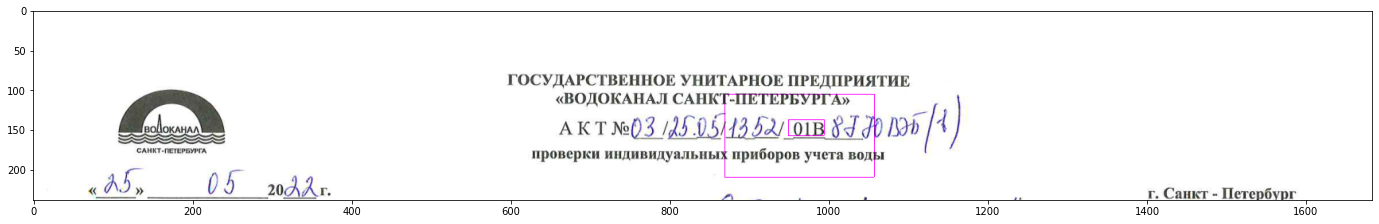


ГОТОВО! Файл идентифицирован как акт: 01B Точность распознавания: 0.98
-----------------------------------------------------------------------------------------------------------------
Обрабатывается файл: oc03057120220601165156_1_cor_180.png


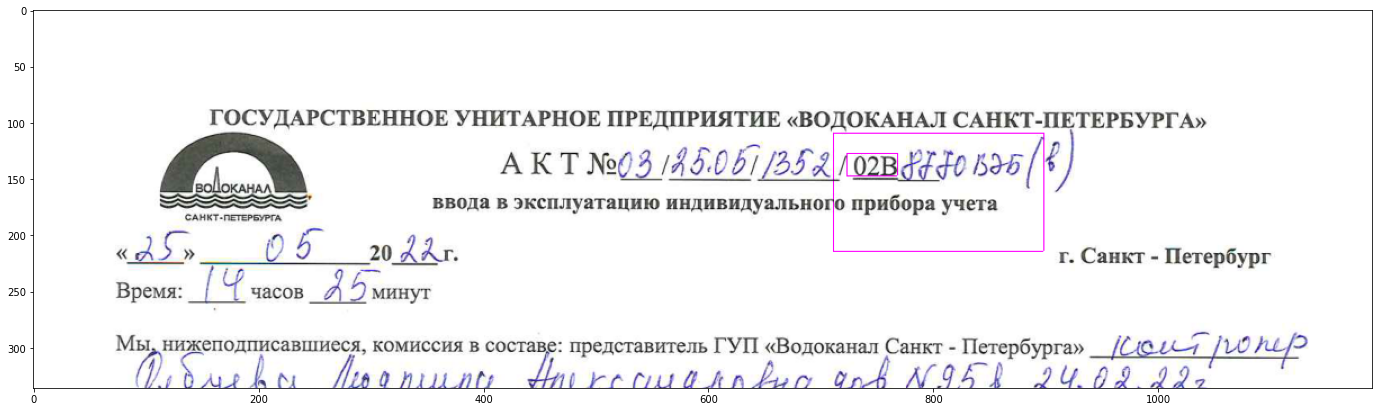


ГОТОВО! Файл идентифицирован как акт: 02B Точность распознавания: 0.99
-----------------------------------------------------------------------------------------------------------------
Обрабатывается файл: oc03069220220602150035_002_0_cor_0.png


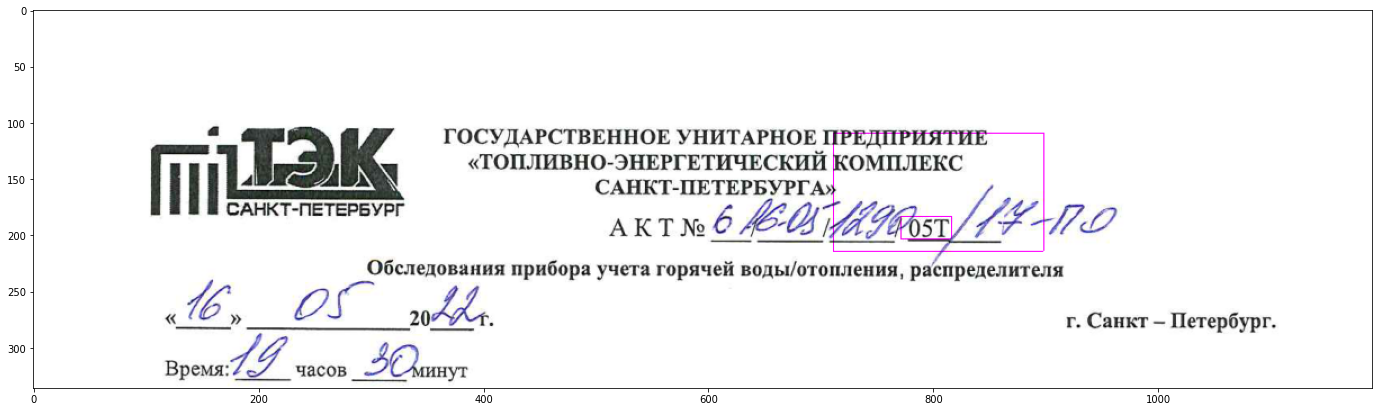


ГОТОВО! Файл идентифицирован как акт: 05T Точность распознавания: 1.0
-----------------------------------------------------------------------------------------------------------------
Обрабатывается файл: oc03069220220602150035_005_0_cor_0.png


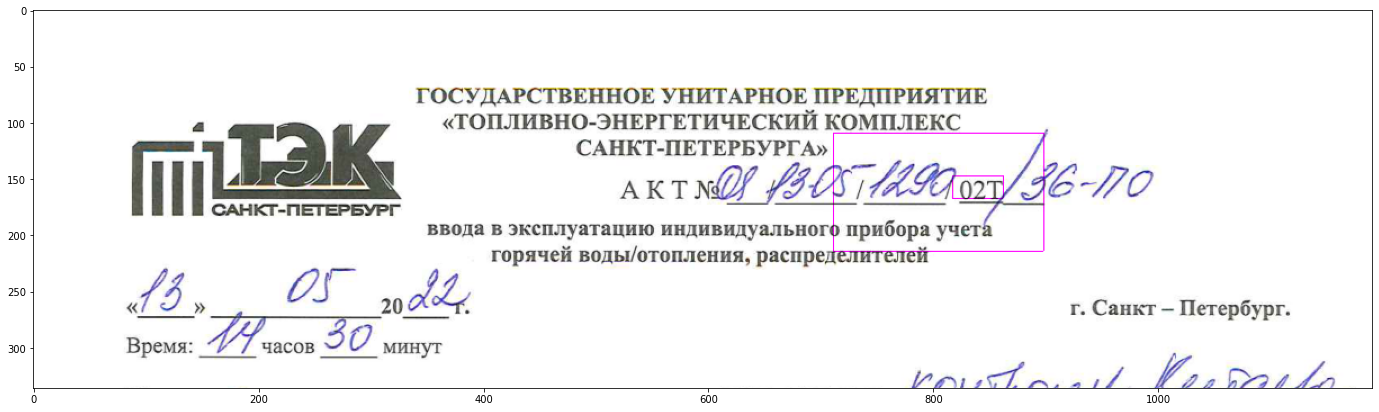


ГОТОВО! Файл идентифицирован как акт: 02T Точность распознавания: 0.98
-----------------------------------------------------------------------------------------------------------------
Обрабатывается файл: oc03069220220602150035_006_0_cor_90.png


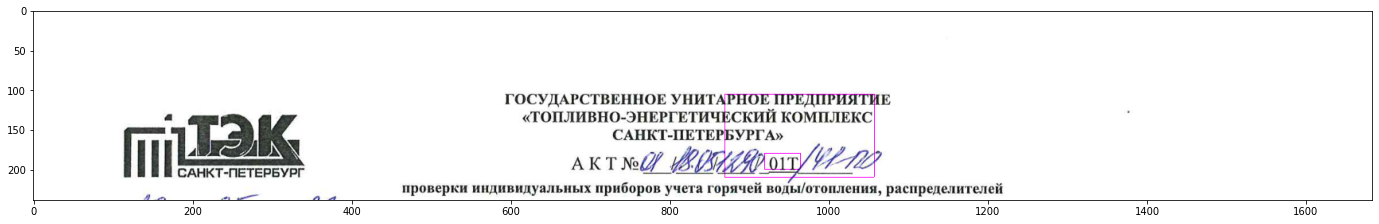


ГОТОВО! Файл идентифицирован как акт: 01T Точность распознавания: 0.97
-----------------------------------------------------------------------------------------------------------------
Обрабатывается файл: oc03069220220602150035_009_0_cor_90.png


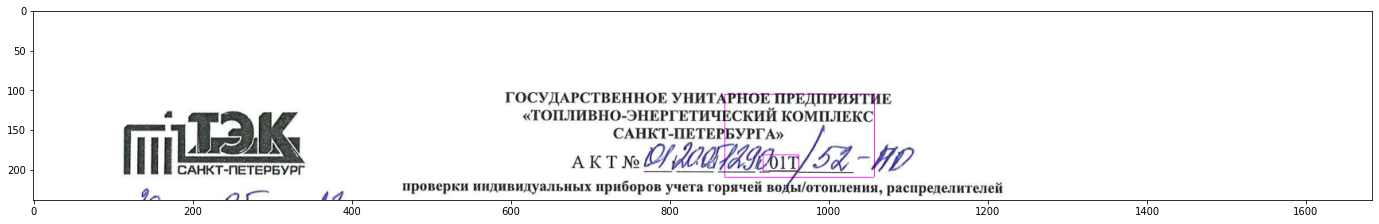


ГОТОВО! Файл идентифицирован как акт: 01T Точность распознавания: 0.97
-----------------------------------------------------------------------------------------------------------------
Обрабатывается файл: oc03095520220603150058_0_cor_0.png


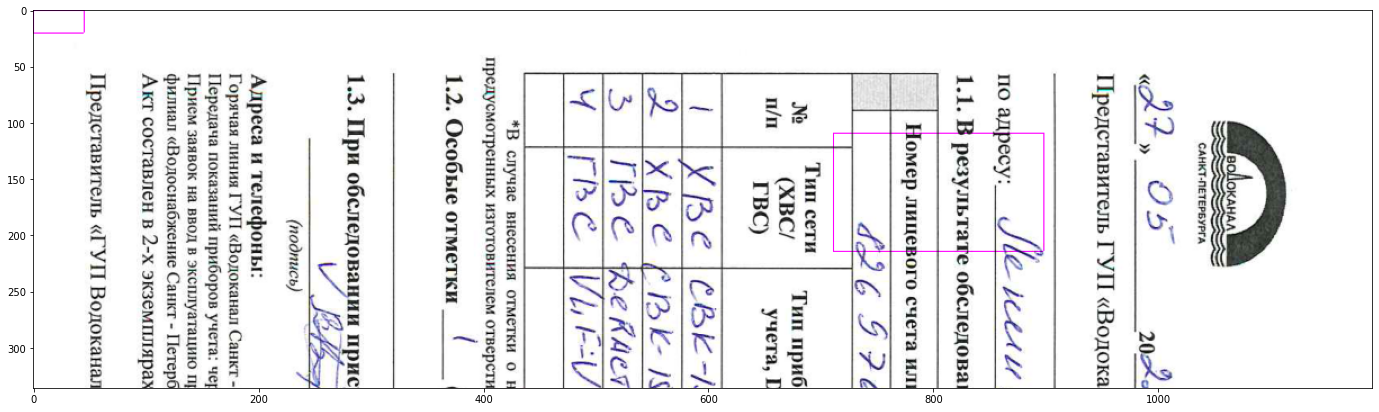


ГОТОВО! Файл идентифицирован как акт: unknown Точность распознавания: 0
-----------------------------------------------------------------------------------------------------------------
Обрабатывается файл: oc03095520220603150058_1_cor_0.png


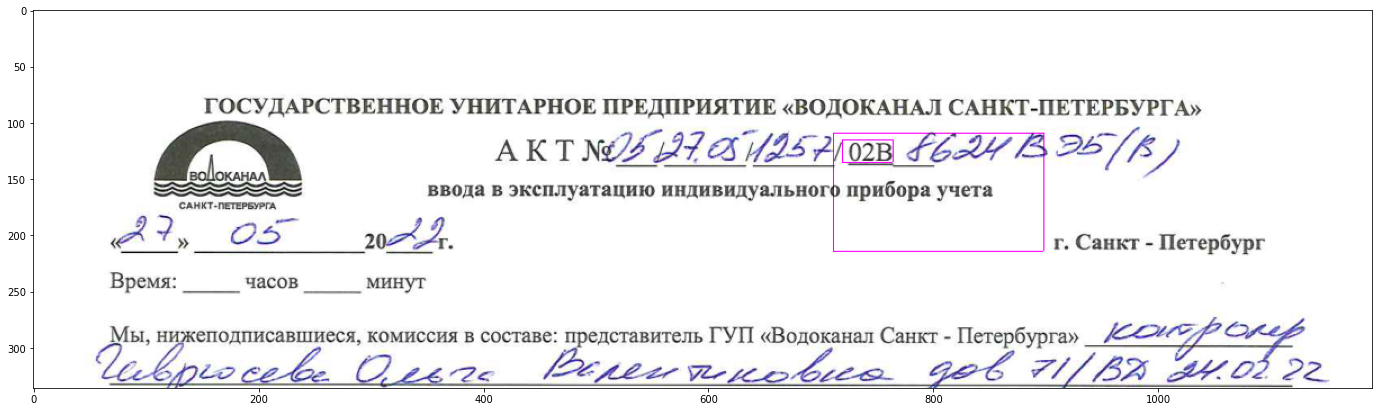


ГОТОВО! Файл идентифицирован как акт: 02B Точность распознавания: 0.99
-----------------------------------------------------------------------------------------------------------------
Обрабатывается файл: oc03095520220603150058_2_cor_0.png


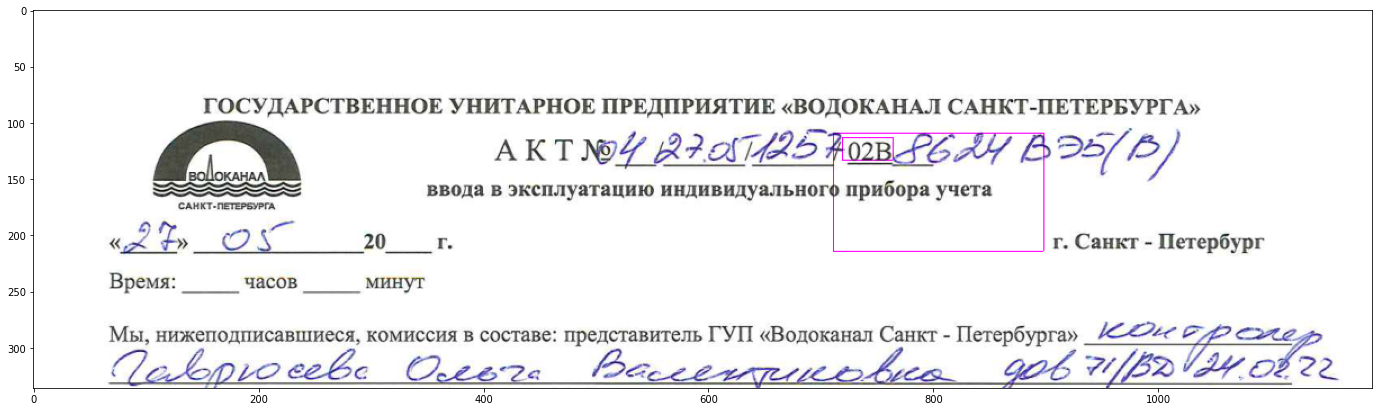


ГОТОВО! Файл идентифицирован как акт: 02B Точность распознавания: 0.98
-----------------------------------------------------------------------------------------------------------------


In [33]:
for row in range(len(file_list['png_cor'])):
    filename = file_list.loc[row,'png_cor']
        
    print(color.BOLD + color.RED + 'Обрабатывается файл: ' + color.END + color.UNDERLINE + filename + color.END)
    
    image = np.array(Image.open(path_png_cor+filename))#/255
    im_shape = image.shape
    x_start, x_max, y_start, y_max = start_point(im_shape)
    
    #fig = plt.figure(figsize=(6,4))
    #plt.imshow(image[x_start:x_max, y_start:y_max,:])
    #plt.show()
        
    
    max_proba, fin_clas, fin_bukva, x_point, y_point = right_sroke(image, filename)
        
    #print(filename)
    #print(max_proba, fin_clas, fin_bukva, x_point, y_point)
    
           
    #запись выровненного изображения в файл
    #papka = fin_bukva + '\\' #local
    papka = fin_bukva + '/' #server
    name = filename.strip('.png') + '_' + fin_bukva + '.png'
    #name = fin_bukva + '.png'
    
    img_new = drow_frame(x_start, x_max, y_start, y_max, filename, x_point, y_point)
    Image.fromarray(img_new).convert("RGB").save(path_png_detected + papka + name)
    #Image.open(path_png+filename).save(path_png_detected + name)
    
    
    #fig = plt.figure(figsize=(6,4))
    #plt.imshow(image[x_point:x_point+mask_heght,y_point:y_point+mask_widht,:]) 
    #plt.show()
    print(color.BOLD + color.RED)
    print('ГОТОВО! Файл идентифицирован как акт: ' + color.END + color.BOLD + color.BLUE + fin_bukva + color.END, 
          color.BOLD + color.RED + 'Точность распознавания:', color.BOLD + color.BLUE + str(max_proba) + color.END) 
    #print(max_proba, fin_clas, fin_bukva, x_point, y_point)
    print('-----------------------------------------------------------------------------------------------------------------')
    
    file_list.loc[row,'mask'] = fin_bukva
    file_list.loc[row,'accuracy'] = max_proba

#print(color.BOLD + color.BLUE + 'КЛАССИФИКАЦИЯ АКТОВ ЗАВЕРШЕНА!!!' + color.END) 

In [34]:
print(color.BOLD + color.PURPLE + 'КЛАССИФИКАЦИЯ АКТОВ ЗАВЕРШЕНА!!! Результаты представлены в таблице.' + color.END) 
file_list

КЛАССИФИКАЦИЯ АКТОВ ЗАВЕРШЕНА!!! Результаты представлены в таблице.


,pdf,png,orient,png_cor,mask,accuracy
0,oc03057120220601165156,oc03057120220601165156_0.png,right,oc03057120220601165156_0_cor_90.png,01B,0.98
1,oc03057120220601165156,oc03057120220601165156_1.png,upside_down,oc03057120220601165156_1_cor_180.png,02B,0.99
2,oc03069220220602150035_002,oc03069220220602150035_002_0.png,norm,oc03069220220602150035_002_0_cor_0.png,05T,1.0
3,oc03069220220602150035_005,oc03069220220602150035_005_0.png,norm,oc03069220220602150035_005_0_cor_0.png,02T,0.98
4,oc03069220220602150035_006,oc03069220220602150035_006_0.png,right,oc03069220220602150035_006_0_cor_90.png,01T,0.97
5,oc03069220220602150035_009,oc03069220220602150035_009_0.png,right,oc03069220220602150035_009_0_cor_90.png,01T,0.97
6,oc03095520220603150058,oc03095520220603150058_0.png,norm,oc03095520220603150058_0_cor_0.png,unknown,0
7,oc03095520220603150058,oc03095520220603150058_1.png,norm,oc03095520220603150058_1_cor_0.png,02B,0.99
8,oc03095520220603150058,oc03095520220603150058_2.png,norm,oc03095520220603150058_2_cor_0.png,02B,0.98


In [35]:
file_list.to_csv(path_png_detected + 'recognition_results_log.csv')

# THE END!